### Algorithmic Trading using unsupervised learning (k means clustering)

This project aims to leverage K-means clustering to categorize stocks into distinct groups, with the goal of identifying tradable stocks that hold potential for profitability. By comparing against the SPY benchmark, we will evaluate a strategy focused on selecting stocks that currently exhibit weaker buying positions. The objective is to capitalize on their potential for upward movement, thus potentially yielding profitable opportunities.

#### *Use recent sp500 stocks list, meaning there may be a survivorship bias in the list as sp500 may/may not remove stock that are failing.

In [1]:
# !pip install statsmodels
# !pip install pandas_datareader
# !pip install PyPortfolioOpt
# !pip install datetime
# !pip install pandas_ta

Download SP500 list and stock price

In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-') #BRK.B, '.' will cause error later on.

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-12-12'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8) #8yrs timeframe from 2023-12-12

df = yf.download(tickers=symbols_list,
                start=start_date,
                 end=end_date)#.fillna(0) 

df

[*********************100%%**********************]  503 of 503 completed


Adj Close                                                 \
                     A        AAL        AAPL        ABBV        ABNB   
Date                                                                    
2015-12-14   37.619194  39.917316   25.600254   39.242085         NaN   
2015-12-15   38.142597  40.710499   25.147333   39.914524         NaN   
2015-12-16   38.722073  41.283886   25.340790   40.792233         NaN   
2015-12-17   38.114552  40.576706   24.803658   39.907440         NaN   
2015-12-18   37.478996  39.267475   24.132244   39.454430         NaN   
...                ...        ...         ...         ...         ...   
2023-12-05  127.664078  13.130000  193.419998  144.570007  133.710007   
2023-12-06  128.692337  13.480000  192.320007  146.380005  135.309998   
2023-12-07  128.462723  13.910000  194.270004  147.970001  139.839996   
2023-12-08  126.985222  13.760000  195.710007  149.279999  140.679993   
2023-12-11  128.752243  13.720000  193.179993  151.240005  142.910004   

                                                                       ...  \
                   ABT       ACGL         ACN        ADBE         ADI  ...   
Date                                                                   ...   
2015-12-14   38.574707  23.276667   93.589180   93.260002   48.200256  ...   
2015-12-15   39.246174  23.219999   93.905952   94.019997   47.971222  ...   
2015-12-16   39.642155  23.383333   95.982605   95.559998   48.802544  ...   
2015-12-17   38.962082  23.309999   90.861420   94.199997   47.606445  ...   
2015-12-18   37.619156  23.360001   89.691116   91.309998   46.800564  ...   
...                ...        ...         ...         ...         ...  ...   
2023-12-05  104.349998  81.849998  335.829987  602.219971  180.630005  ...   
2023-12-06  104.940002  79.970001  335.410004  595.700012  180.570007  ...   
2023-12-07  104.050003  78.339996  335.100006  608.780029  184.380005  ...   
2023-12-08  104.510002  79.300003  337.230011  610.010010  184.880005  ...   
2023-12-11  106.220001  79.610001  342.309998  625.200012  190.130005  ...   

             Volume                                                         \
               WYNN      XEL       XOM     XRAY      XYL      YUM      ZBH   
Date                                                                         
2015-12-14  2906700  3822300  21976500   751600  1344400  6037496  1126923   
2015-12-15  4010600  3306600  24366800  1026200  1389500  6818126  1436541   
2015-12-16  4192400  4072400  17233900  1427300  1227000  4412948  1061930   
2015-12-17  3748700  2869000  17362900   654700  1178500  4493765  1385144   
2015-12-18  7710500  6339800  28836000  1265900  1973700  6995200  1226215   
...             ...      ...       ...      ...      ...      ...      ...   
2023-12-05  2366600  3110400  22250300  3214700  1133200  1600000  1028400   
2023-12-06  2340000  3779800  31154800  1946200   991800  1596600  1385800   
2023-12-07  1804800  3749600  29990700  2833200   933200  1901700  1141300   
2023-12-08  2344800  4343700  22069200  3564800  2103800  1192900  1357900   
2023-12-11  1973900  4332500  22252300  2238400  1318900  1182400  2066300   

                                        
               ZBRA      ZION      ZTS  
Date                                    
2015-12-14  1882600   4891300  3895900  
2015-12-15   854200   3638200  4154100  
2015-12-16   381900   4715500  3441900  
2015-12-17  1157300   2204100  2642300  
2015-12-18  1935800  11655100  5439700  
...             ...       ...      ...  
2023-12-05   243300   2501500  1425900  
2023-12-06   222300   2393500  1552900  
2023-12-07   319100   1610300  1088600  
2023-12-08   229900   2023400  1474600  
2023-12-11   363100   1241200  3199200  

[2012 rows x 3018 columns]

In [3]:
df = df.stack()
df.index.names = ['date', 'ticker'] # 'date' = 0, 'ticker' = 1
df.columns = df.columns.str.lower()
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-12-14 A        37.619194   40.250000   40.540001   39.900002   40.220001   
           AAL      39.917316   41.770000   42.869999   41.080002   42.259998   
           AAPL     25.600254   28.120001   28.170000   27.447500   28.045000   
           ABBV     39.242085   55.439999   55.480000   53.240002   53.709999   
           ABT      38.574707   44.810001   44.830002   43.959999   44.450001   
...                       ...         ...         ...         ...         ...   
2023-12-11 YUM     126.629997  126.629997  126.720001  124.410004  124.540001   
           ZBH     117.745140  117.980003  118.269997  116.959999  117.169998   
           ZBRA    239.649994  239.649994  239.759995  235.940002  235.940002   
           ZION     38.630001   38.630001   39.090000   38.430000   38.770000   
           ZTS     189.460007  189.460007  190.149994  184.679993  185.169998   

                        volume  
date       ticker               
2015-12-14 A         2310500.0  
           AAL      10750500.0  
           AAPL    257274800.0  
           ABBV      9419500.0  
           ABT       6173500.0  
...                        ...  
2023-12-11 YUM       1182400.0  
           ZBH       2066300.0  
           ZBRA       363100.0  
           ZION      1241200.0  
           ZTS       3199200.0  

[994248 rows x 6 columns]

Calculate different technical indicators and features for each stock

1. Garman-Klass Volatility

2. RSI

3. Bollinger Bands

4. ATR

5. MACD

6. Dollar Volume

In [4]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - ((2*np.log(2)-1))*((np.log(df['adj close'])-np.log(df['open'])))**2

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close =x, length=20))
# df.xs('TSLA', level=1)['rsi'].plot()

# transform only works for 1 column ['adj close']
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
             low=stock_data['low'],
             close=stock_data['close'],
             length=14)
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6 #since millions of stocks traded per day
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-12-14 A        37.619194   40.250000   40.540001   39.900002   40.220001   
           AAL      39.917316   41.770000   42.869999   41.080002   42.259998   
           AAPL     25.600254   28.120001   28.170000   27.447500   28.045000   
           ABBV     39.242085   55.439999   55.480000   53.240002   53.709999   
           ABT      38.574707   44.810001   44.830002   43.959999   44.450001   
...                       ...         ...         ...         ...         ...   
2023-12-11 YUM     126.629997  126.629997  126.720001  124.410004  124.540001   
           ZBH     117.745140  117.980003  118.269997  116.959999  117.169998   
           ZBRA    239.649994  239.649994  239.759995  235.940002  235.940002   
           ZION     38.630001   38.630001   39.090000   38.430000   38.770000   
           ZTS     189.460007  189.460007  190.149994  184.679993  185.169998   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-12-14 A         2310500.0         -0.001600        NaN       NaN   
           AAL      10750500.0         -0.000347        NaN       NaN   
           AAPL    257274800.0         -0.002876        NaN       NaN   
           ABBV      9419500.0         -0.037201        NaN       NaN   
           ABT       6173500.0         -0.007572        NaN       NaN   
...                        ...               ...        ...       ...   
2023-12-11 YUM       1182400.0          0.000062  54.676193  4.826270   
           ZBH       2066300.0          0.000053  62.899029  4.684821   
           ZBRA       363100.0          0.000035  60.455794  5.342779   
           ZION      1241200.0          0.000140  62.277408  3.518694   
           ZTS       3199200.0          0.000223  67.041797  5.141187   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-12-14 A            NaN       NaN       NaN       NaN      86.919148  
           AAL          NaN       NaN       NaN       NaN     429.131110  
           AAPL         NaN       NaN       NaN       NaN    6586.300243  
           ABBV         NaN       NaN       NaN       NaN     369.640815  
           ABT          NaN       NaN       NaN       NaN     238.140954  
...                     ...       ...       ...       ...            ...  
2023-12-11 YUM     4.826270  4.826270  0.076048  0.063510     149.727309  
           ZBH     4.684821  4.684821 -0.764913  0.959430     243.296783  
           ZBRA    5.342779  5.342779 -0.298211  0.703096      87.016913  
           ZION    3.518694  3.518694  0.006076  1.209022      47.947557  
           ZTS     5.141187  5.141187  0.606049  1.556490     606.120453  

[994248 rows x 14 columns]

Aggregate on monthly level and filter for each month only the top 100 most liquid stocks. 

In [5]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                         'high', 'low', 'close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].reset_index('date').set_index('date').resample('M').mean().stack('ticker').to_frame('dollar_volume'),
          df.unstack()[last_cols].reset_index('date').set_index('date').resample('M').last().stack('ticker')],
          axis=1).dropna()

# Calculate 5 year rolling average of dollar volume for each stocks before filtering
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)

data = data[data['dollar_vol_rank']<100].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-12-31 AAL      45.118095  0.403533  3.813338  3.813338  3.813338   
           AAPL     26.946928 -1.126230  3.274855  3.274855  3.274855   
           ABBV     46.037807 -1.266275  3.809937  3.809937  3.809937   
           ABT      33.897533 -1.188688  3.535751  3.535751  3.535751   
           ADBE    102.949997 -1.238526  4.624229  4.624229  4.624229   
...                       ...       ...       ...       ...       ...   
2023-12-31 V       256.519989 -0.236459  5.508922  5.508922  5.508922   
           VZ       37.669998 -0.981541  3.598616  3.598616  3.598616   
           WFC      46.000000 -0.867779  3.737698  3.737698  3.737698   
           WMT     151.240005  0.491560  4.996148  4.996148  4.996148   
           XOM      99.620003  0.456581  4.601449  4.601449  4.601449   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2016-12-31 AAL            -0.000637  1.013543  52.919074  
           AAPL           -0.002296 -0.123124  57.499183  
           ABBV           -0.036939 -0.011422  54.830695  
           ABT            -0.005705 -0.358233  45.324658  
           ADBE            0.000098 -0.226219  44.925263  
...                             ...       ...        ...  
2023-12-31 V               0.000039  1.379110  66.352731  
           VZ              0.000185  1.874967  61.561395  
           WFC             0.000098  1.419746  69.511229  
           WMT             0.000080 -2.002140  37.566609  
           XOM             0.000082 -1.583593  37.916420  

[8415 rows x 8 columns]

#### 4. Calculate monthly returns for different time-horizons to add to features

In [6]:
# Remove outliers by percentile of 0.5%
def calculate_returns(df):
    outlier_percentile = 0.005
    lags = [1, 2, 3, 6, 9, 12]

    for i in lags:
        df[f'return_{i}m'] = (df['adj close']
                            .pct_change(i)
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_percentile),
                                                  upper=x.quantile(1-outlier_percentile)))
                            .add(1)
                            .pow(1/i)
                            .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-12-31 AAL      50.711872 -0.096137  3.884601  3.884601  3.884601   
           AAPL     40.006569 -0.994113  3.703448  3.703448  3.703448   
           ABBV     73.694962 -0.701084  4.289143  4.289143  4.289143   
           ABT      51.533813 -1.132249  3.904342  3.904342  3.904342   
           ADBE    175.240005 -1.005776  5.137116  5.137116  5.137116   
...                       ...       ...       ...       ...       ...   
2023-12-31 V       256.519989 -0.236459  5.508922  5.508922  5.508922   
           VZ       37.669998 -0.981541  3.598616  3.598616  3.598616   
           WFC      46.000000 -0.867779  3.737698  3.737698  3.737698   
           WMT     151.240005  0.491560  4.996148  4.996148  4.996148   
           XOM      99.620003  0.456581  4.601449  4.601449  4.601449   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-12-31 AAL            -0.000305  1.246028  59.214213   0.030501   
           AAPL           -0.001526 -0.233559  47.784551  -0.015246   
           ABBV           -0.031544  0.195080  55.000919  -0.002167   
           ABT            -0.004710  0.241682  59.877880   0.012418   
           ADBE            0.000056 -0.237144  51.008414  -0.034331   
...                             ...       ...        ...        ...   
2023-12-31 V               0.000039  1.379110  66.352731  -0.000623   
           VZ              0.000185  1.874967  61.561395  -0.017219   
           WFC             0.000098  1.419746  69.511229   0.031621   
           WMT             0.000080 -2.002140  37.566609  -0.024975   
           XOM             0.000082 -1.583593  37.916420  -0.030368   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-12-31 AAL      0.055325   0.031653   0.006292   0.023994    0.009787  
           AAPL     0.002359   0.032902   0.028535   0.019684    0.033479  
           ABBV     0.035171   0.031007   0.051953   0.047851    0.039985  
           ABT      0.025851   0.024323   0.028884   0.030147    0.035524  
           ADBE     0.000228   0.055134   0.036359   0.033622    0.045323  
...                      ...        ...        ...        ...         ...  
2023-12-31 V        0.045673   0.037766   0.013613   0.015115    0.018395  
           VZ       0.035521   0.054809   0.008652   0.002604    0.002167  
           WFC      0.080260   0.043369   0.015380   0.026109    0.011637  
           WMT     -0.036173  -0.017237  -0.005198   0.004056    0.006660  
           XOM     -0.025449  -0.050878  -0.009378  -0.007760   -0.005673  

[6930 rows x 14 columns]

Download Fama-French Factors and calculate rolling factor betas for each stocks

#### 5. Download Fama-French Factors and calculate Rolling Factor Betas 

To estimate the exposure of assets to common risk factors using linear regression. Market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios.

Using data from "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html#Benchmarks", we can access the historical factor returns and estimate the historical exposures using RollingOLS rolling linear regression. 

Rolling Factor Betas in finance refer to the beta coefficients of a financial asset (such as a stock or portfolio) calculated over a rolling window of time in relation to specific factors.  Rolling factor betas are a vital tool in modern portfolio theory, providing dynamic insights into how different macroeconomic or market factors affect the returns of securities or portfolios


1. Mkt-RF (Market Risk Factor):

     - This is the excess return of the market over the risk-free rate. It represents the additional return investors expect for taking on the higher risk of investing in the stock market over a risk-free asset.
     
    
2. SMB (Small Minus Big):

    - SMB stands for "Small Minus Big" and represents the size premium. It measures the additional return investors can expect from investing in companies with smaller market capitalizations over companies with larger market capitalizations.


3. HML (High Minus Low):

    - HML stands for "High Minus Low" and is the value premium. This factor looks at the excess returns of stocks with high book-to-market values (value stocks) over those with low book-to-market values (growth stocks).


4. RMW (Robust Minus Weak):

    - RMW, introduced in the five-factor model, represents the profitability premium. It captures the excess returns of stocks with high operating profitability over those with low operating profitability.


5. CMA (Conservative Minus Aggressive):

    - Also introduced in the five-factor model, CMA stands for "Conservative Minus Aggressive" and represents the investment factor. It measures the excess returns of companies that are more conservative in their investments (low asset growth) over those that are more aggressive (high asset growth).

In [7]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
              'famafrench',
              start='2010')[0].drop('RF', axis=1) # Monthly factors only

factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()
# factor_data.xs('AAPL', level=1).head()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-12-31 AAL     0.0106 -0.0107  0.0006  0.0074  0.0169   0.030501
           AAPL    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.015246
           ABBV    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.002167
           ABT     0.0106 -0.0107  0.0006  0.0074  0.0169   0.012418
           ADBE    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.034331
...                   ...     ...     ...     ...     ...        ...
2023-11-30 V       0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.094115
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[6834 rows x 6 columns]

Filter out stocks that has less than 10 months of data

In [8]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations>=10]
print(f'The smallest amount of data per month is {valid_stocks.min()}')
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

The smallest amount of data per month is 11


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-12-31 AAL     0.0106 -0.0107  0.0006  0.0074  0.0169   0.030501
           AAPL    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.015246
           ABBV    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.002167
           ABT     0.0106 -0.0107  0.0006  0.0074  0.0169   0.012418
           ADBE    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.034331
...                   ...     ...     ...     ...     ...        ...
2023-11-30 V       0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.094115
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[6811 rows x 6 columns]

In [9]:
betas = (factor_data.groupby(level=1,group_keys=False)
    .apply(lambda x: RollingOLS(endog=x['return_1m'],
                               exog=sm.add_constant(x.drop('return_1m', axis=1)),
                               window=min(24, x.shape[0]),
                               min_nobs=len(x.columns)+1)
    .fit(params_only=True)
    .params
    .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-12-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-11-30 V       1.043156 -0.202817  0.288542  0.501784  0.139105
           VZ      0.444391 -0.662955  0.517142  0.210200 -0.205917
           WFC     1.037897  0.400999  2.011855 -0.363962 -1.477539
           WMT     0.497263  0.081985 -0.730994  0.577485  0.752982
           XOM     0.722440 -0.211055  1.202663  0.229126  0.171951

[6811 rows x 5 columns]

In [10]:
factors = ['Mkt-RF','SMB','HML','RMW','CMA']

data = data.join(betas.groupby('ticker').shift())
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.dropna()
data = data.drop('adj close', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6727 entries, (Timestamp('2017-12-31 00:00:00', freq='M'), 'AAL') to (Timestamp('2023-12-31 00:00:00', freq='M'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               6727 non-null   float64
 1   bb_high           6727 non-null   float64
 2   bb_low            6727 non-null   float64
 3   bb_mid            6727 non-null   float64
 4   garman_klass_vol  6727 non-null   float64
 5   macd              6727 non-null   float64
 6   rsi               6727 non-null   float64
 7   return_1m         6727 non-null   float64
 8   return_2m         6727 non-null   float64
 9   return_3m         6727 non-null   float64
 10  return_6m         6727 non-null   float64
 11  return_9m         6727 non-null   float64
 12  return_12m        6727 non-null   float64
 13  Mkt-RF            6727 non-null   float64
 14  SMB               6727 non-null   float

#### 6. For each month, fit a k-means clustering model and group similar assets based on their features

•	K-means clustering

    o	Takes more time to perform
    o	Less intuitive outputs
    o	Advantage
        +	Easy to implement
        +	Often produces better results than hierarchical clustering
        +	Faster than hierarchical clustering for large dataset
    o	Disadvantage
        -	Difficult to predict the correct number of k clusters
            •	Domain knowledge (Better choice)
            •	Elbow rule
        -	Depends on a random Initialisation step for its outcome. 

In [11]:
def plot_clusters(data):
    
    n = data['cluster'].unique().max()
    colors = ['red', 'green', 'blue', 'black', 'yellow', 'purple']  # Extend this list if you have more than 6 clusters

    for i in range(n + 1):
        cluster_i = data[data['cluster'] == i]
        plt.scatter(cluster_i.iloc[:, 0], cluster_i.iloc[:, 6], color=colors[i % len(colors)], label=f'cluster {i}')
        
    plt.legend()
    plt.show()
    return

In [12]:
from sklearn.cluster import KMeans

n = 5 #hyperparameter for KMeans

target_rsi_value =  np.linspace(30,70,n)
initial_centroids = np.zeros((len(target_rsi_value), 18))
initial_centroids[:, 6] = target_rsi_value
initial_centroids

def get_fixed_clusters(df):
    df['cluster'] = KMeans(n_clusters=n,
                          random_state=0,
                          init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_fixed_clusters)
data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2017-12-31 AAL    -0.096137  3.884601  3.884601  3.884601         -0.000305   
           AAPL   -0.994113  3.703448  3.703448  3.703448         -0.001526   
           ABBV   -0.701084  4.289143  4.289143  4.289143         -0.031544   
           ABT    -1.132249  3.904342  3.904342  3.904342         -0.004710   
           ADBE   -1.005776  5.137116  5.137116  5.137116          0.000056   
...                     ...       ...       ...       ...               ...   
2023-12-31 V      -0.236459  5.508922  5.508922  5.508922          0.000039   
           VZ     -0.981541  3.598616  3.598616  3.598616          0.000185   
           WFC    -0.867779  3.737698  3.737698  3.737698          0.000098   
           WMT     0.491560  4.996148  4.996148  4.996148          0.000080   
           XOM     0.456581  4.601449  4.601449  4.601449          0.000082   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-12-31 AAL     1.246028  59.214213   0.030501   0.055325   0.031653   
           AAPL   -0.233559  47.784551  -0.015246   0.002359   0.032902   
           ABBV    0.195080  55.000919  -0.002167   0.035171   0.031007   
           ABT     0.241682  59.877880   0.012418   0.025851   0.024323   
           ADBE   -0.237144  51.008414  -0.034331   0.000228   0.055134   
...                     ...        ...        ...        ...        ...   
2023-12-31 V       1.379110  66.352731  -0.000623   0.045673   0.037766   
           VZ      1.874967  61.561395  -0.017219   0.035521   0.054809   
           WFC     1.419746  69.511229   0.031621   0.080260   0.043369   
           WMT    -2.002140  37.566609  -0.024975  -0.036173  -0.017237   
           XOM    -1.583593  37.916420  -0.030368  -0.025449  -0.050878   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-12-31 AAL      0.006292   0.023994    0.009787  1.342792  1.310712   
           AAPL     0.028535   0.019684    0.033479  1.298455 -0.301375   
           ABBV     0.051953   0.047851    0.039985  0.477469  0.424561   
           ABT      0.028884   0.030147    0.035524  0.818459 -0.167087   
           ADBE     0.036359   0.033622    0.045323  1.150009 -0.374707   
...                      ...        ...         ...       ...       ...   
2023-12-31 V        0.013613   0.015115    0.018395  0.957121 -0.165528   
           VZ       0.008652   0.002604    0.002167  0.493998 -0.359530   
           WFC      0.015380   0.026109    0.011637  1.082614 -0.097967   
           WMT     -0.005198   0.004056    0.006660  0.615812 -0.450635   
           XOM     -0.009378  -0.007760   -0.005673  1.144310  0.278232   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-12-31 AAL     1.210944  0.087775 -0.127912        3  
           AAPL   -0.605075  0.599914  0.525103        1  
           ABBV   -0.071503  0.303343  0.234361        2  
           ABT    -0.520719  0.281530  0.981606        3  
           ADBE   -0.181883 -0.163152 -0.643062        2  
...                     ...       ...       ...      ...  
2023-12-31 V      -0.027875  0.206931 -0.352572        4  
           VZ      0.069788  0.296344  0.508507        3  
           WFC     1.412178 -0.728791 -0.572781        4  
           WMT    -0.312613  0.322637  0.712727        1  
           XOM     0.647531 -0.483744  0.679699        1  

[6727 rows x 19 columns]

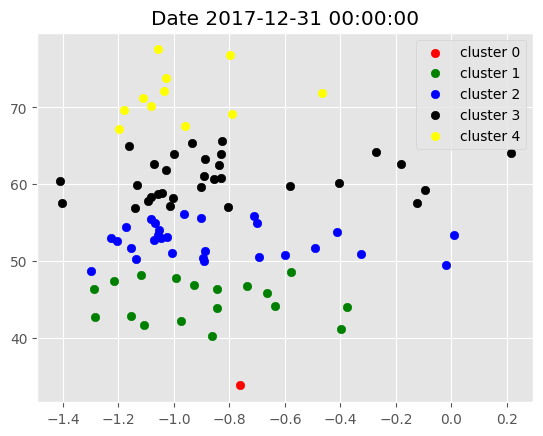

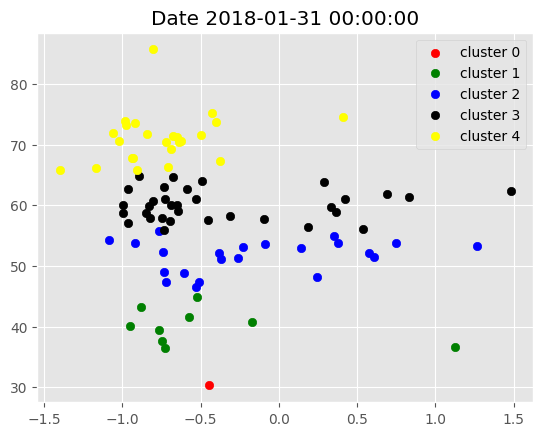

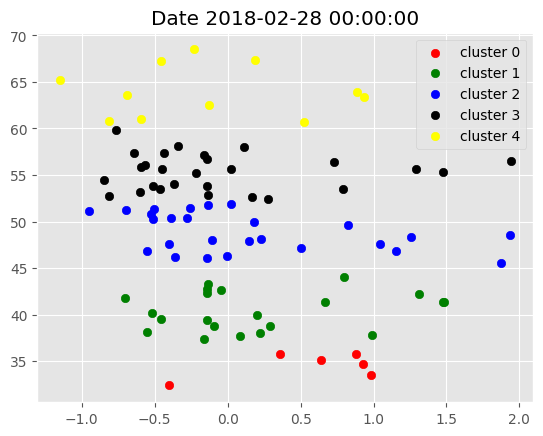

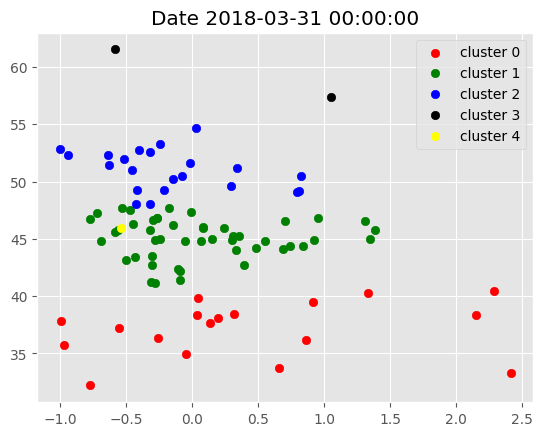

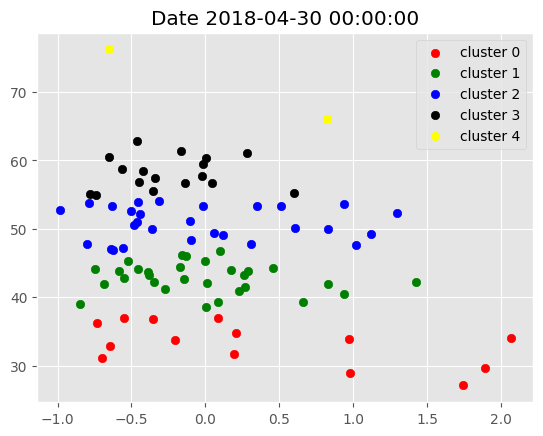

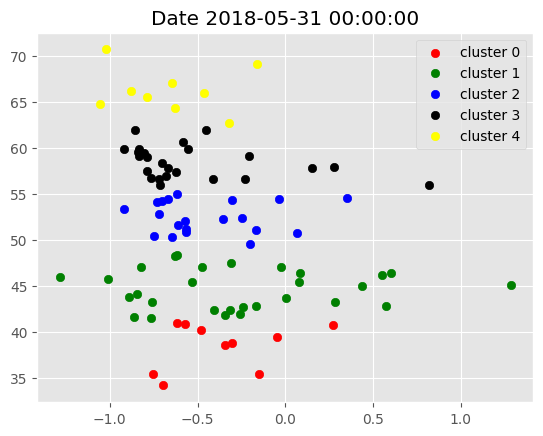

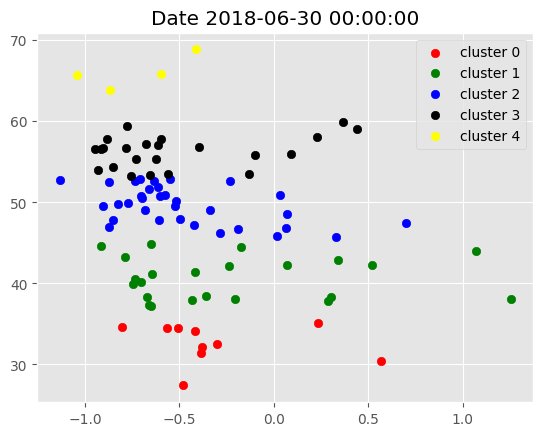

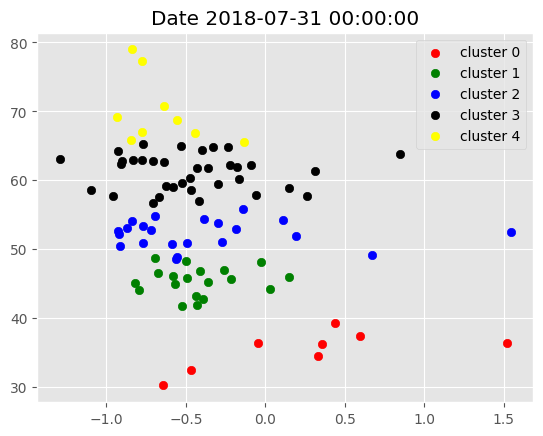

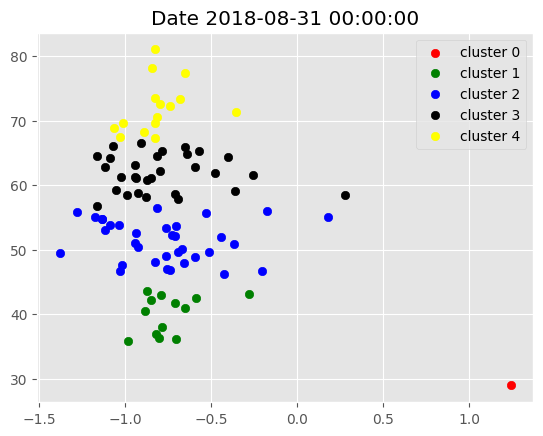

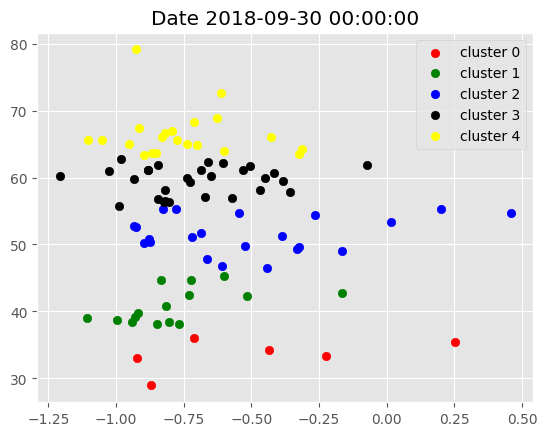

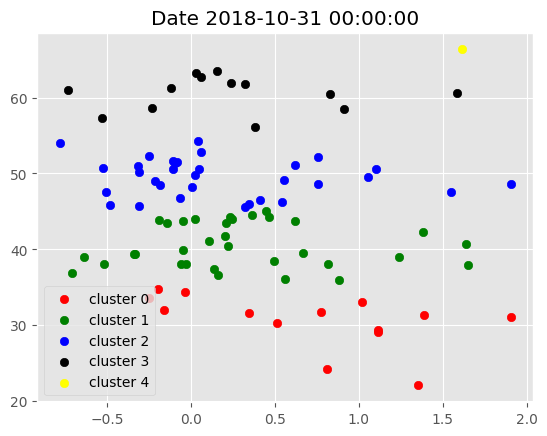

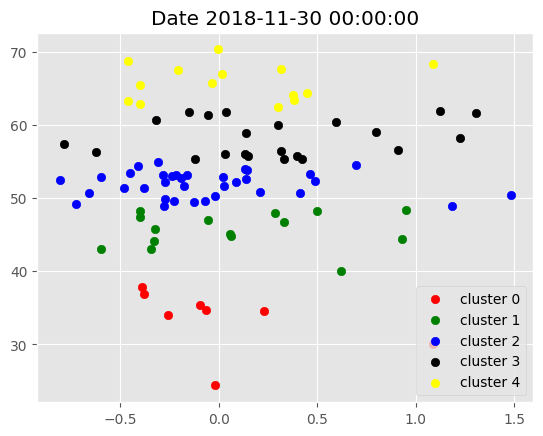

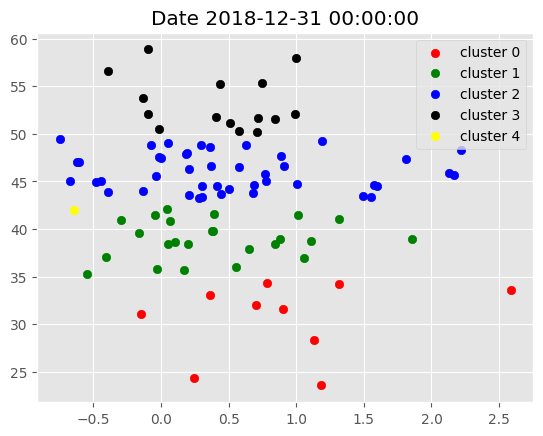

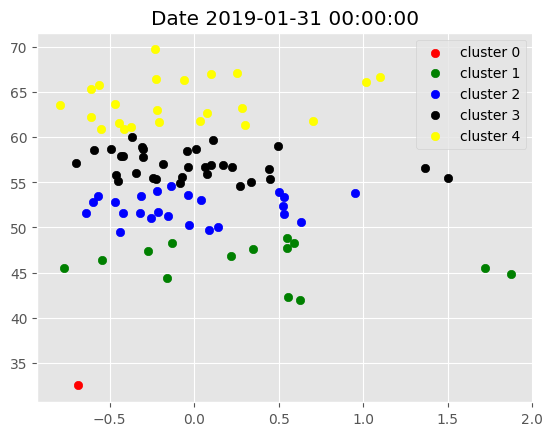

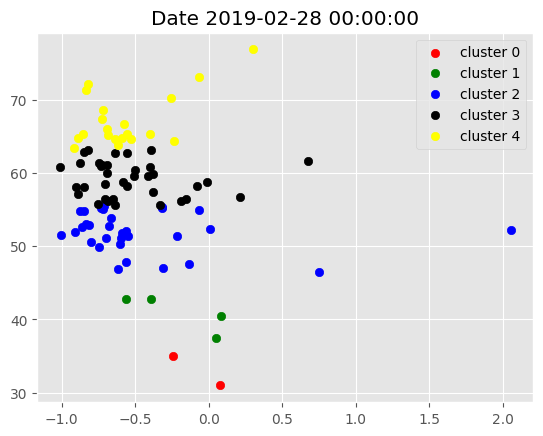

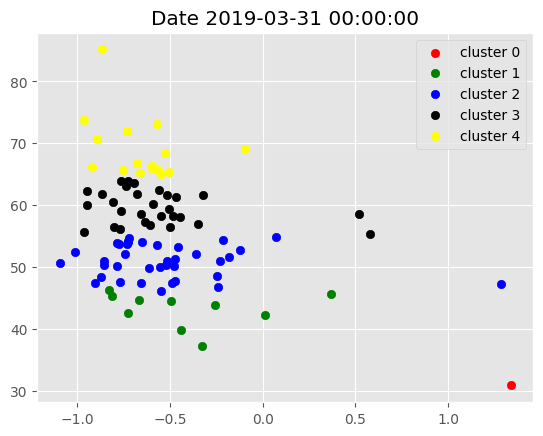

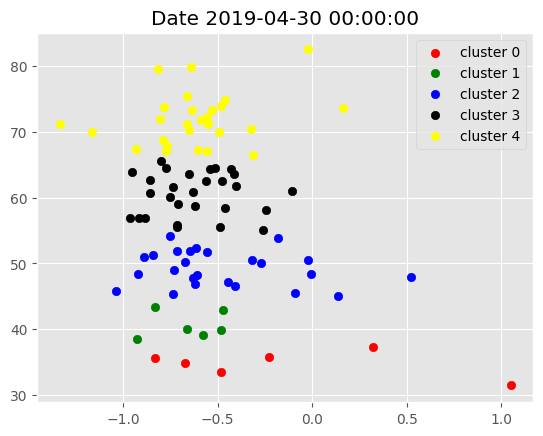

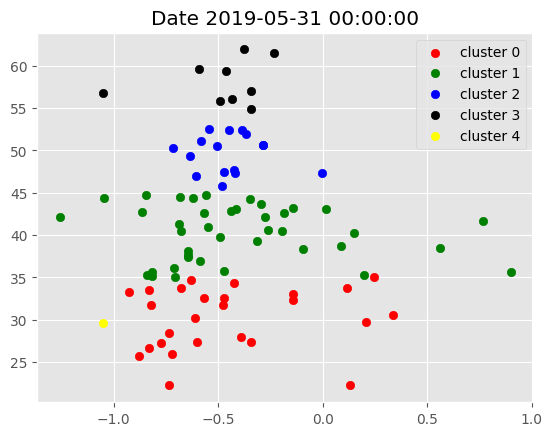

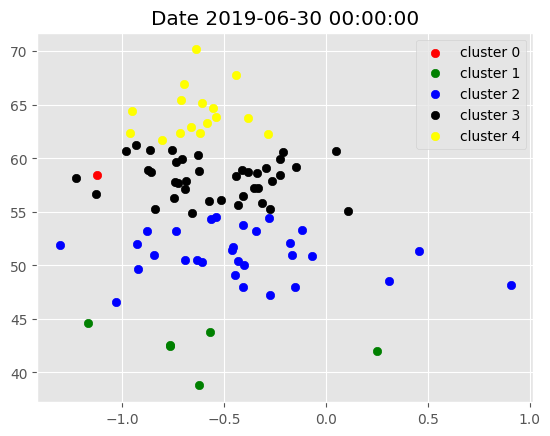

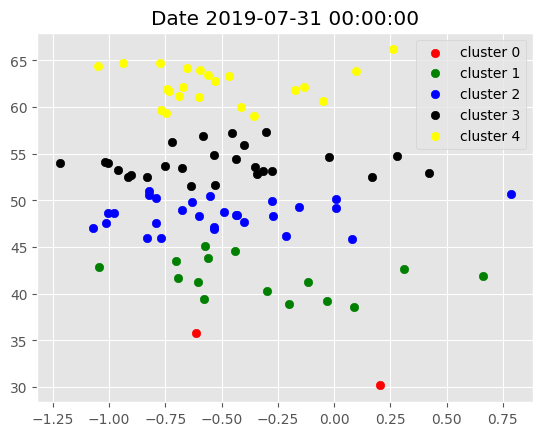

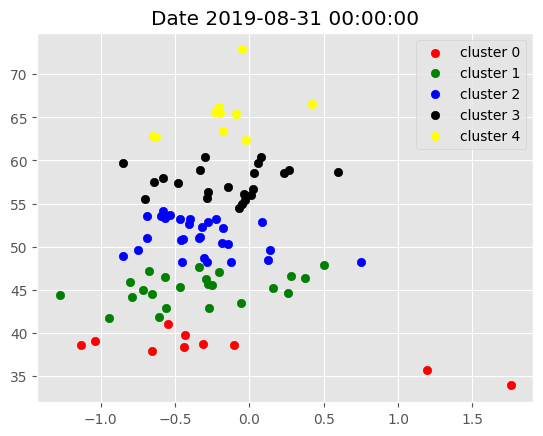

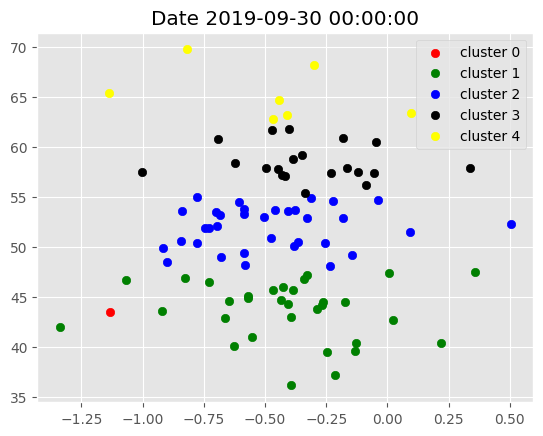

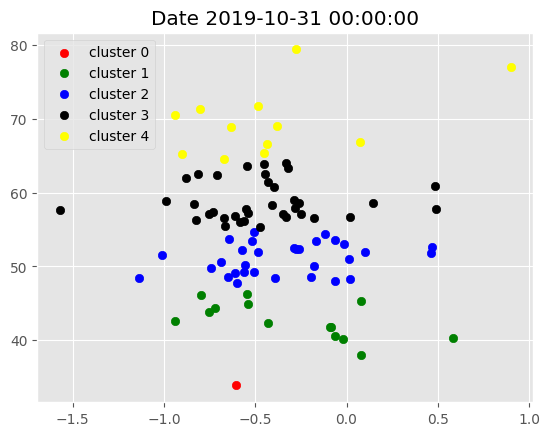

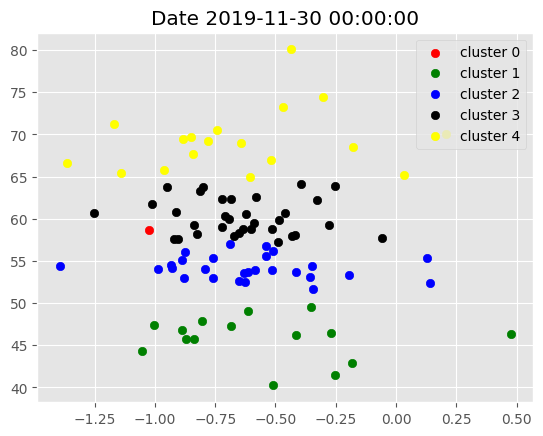

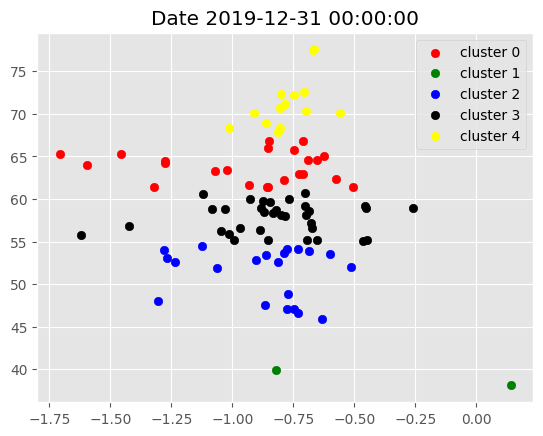

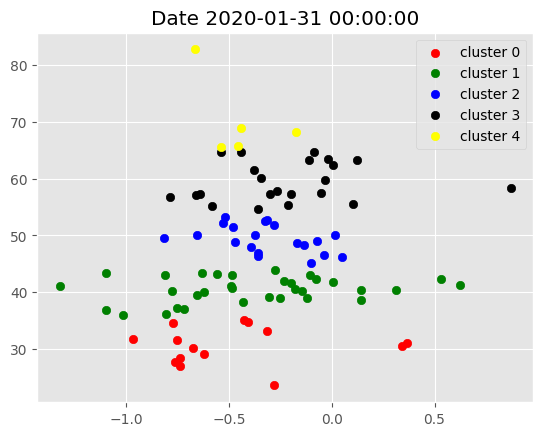

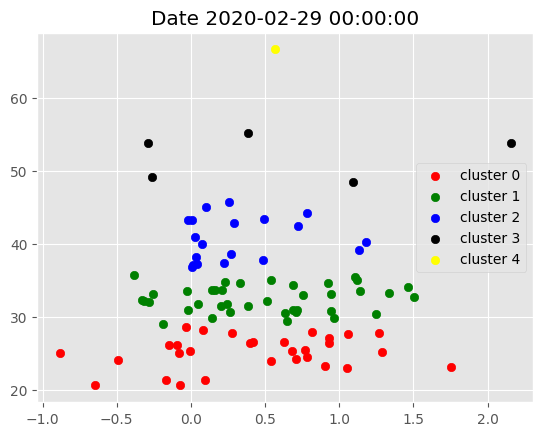

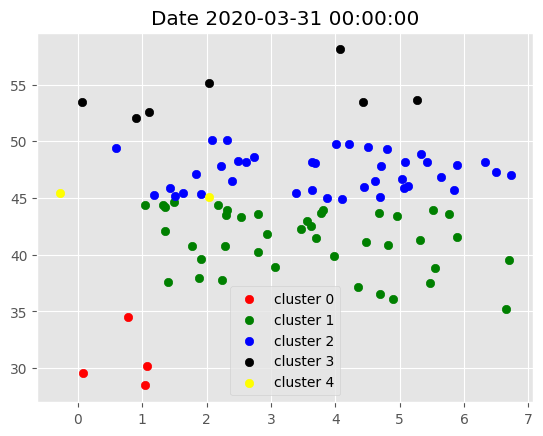

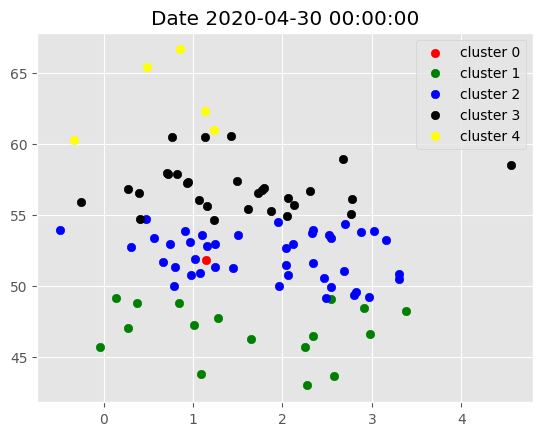

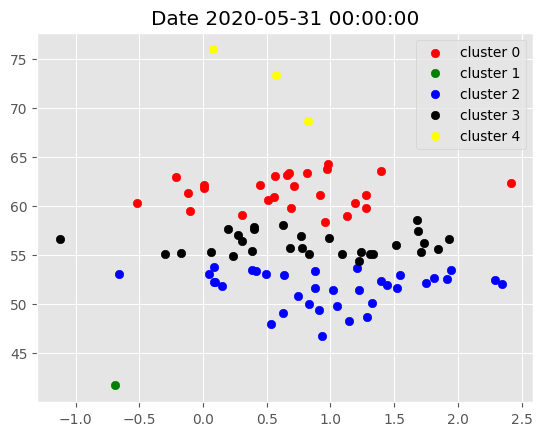

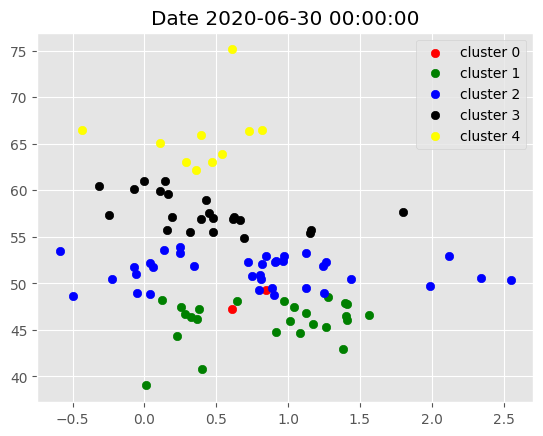

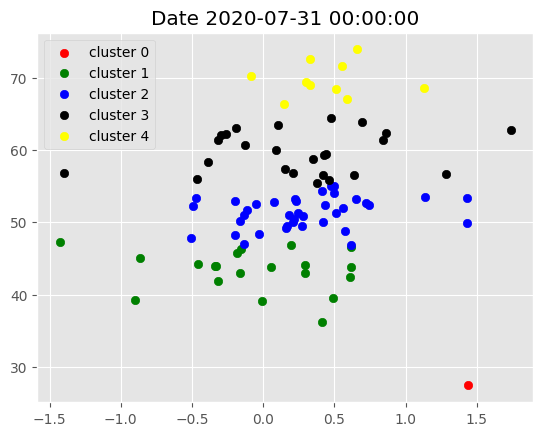

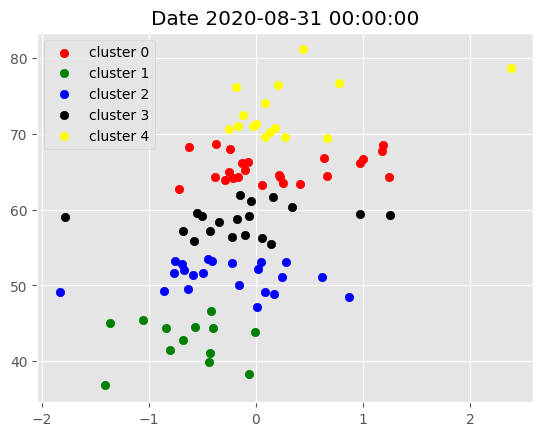

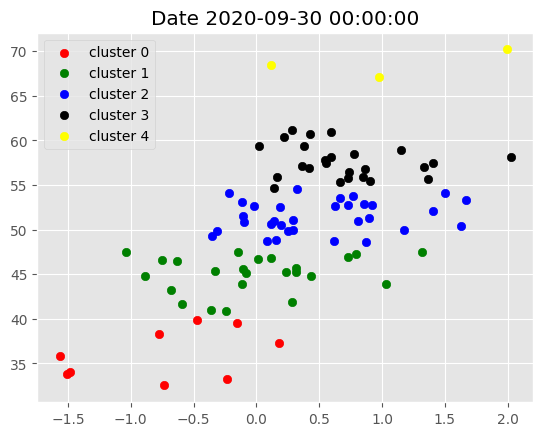

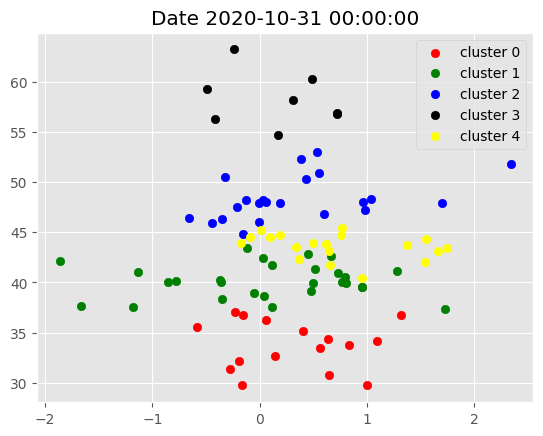

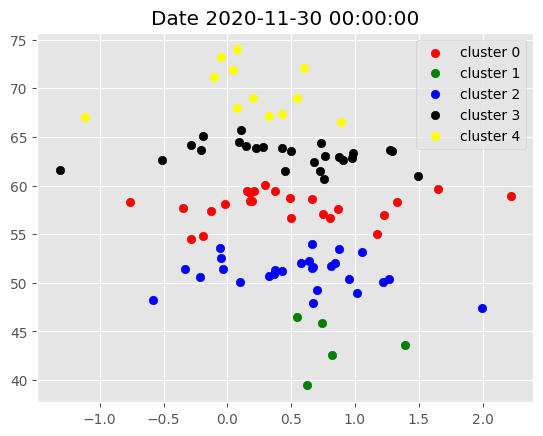

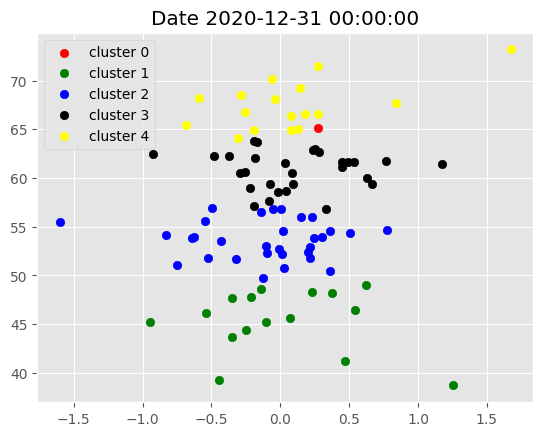

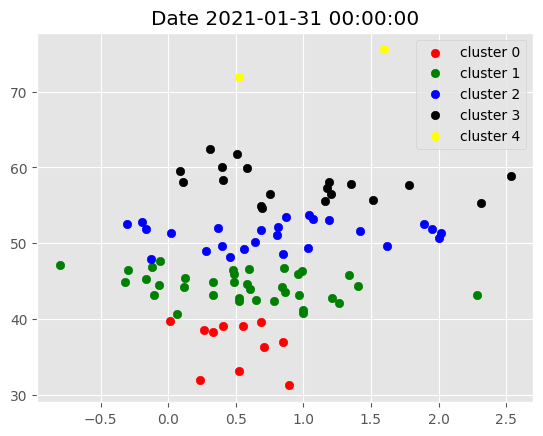

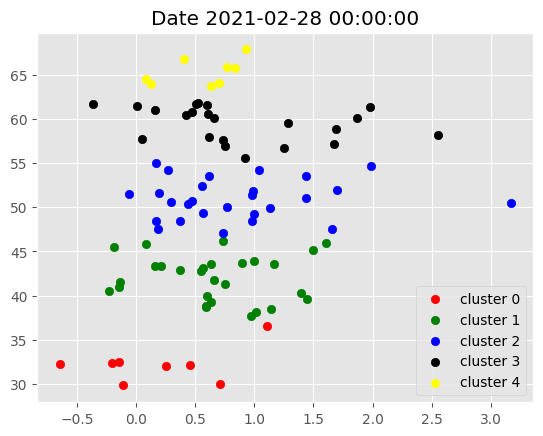

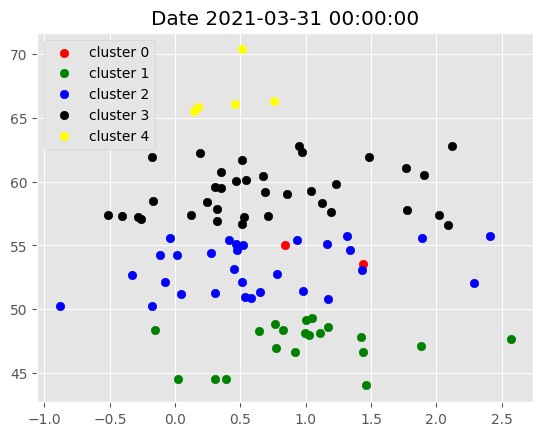

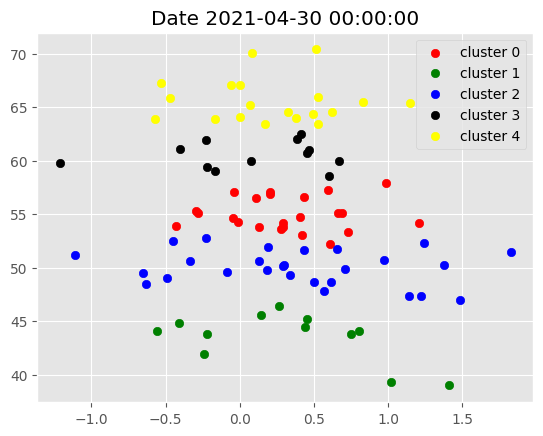

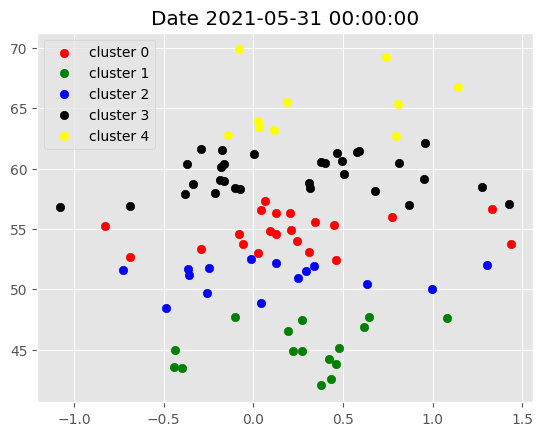

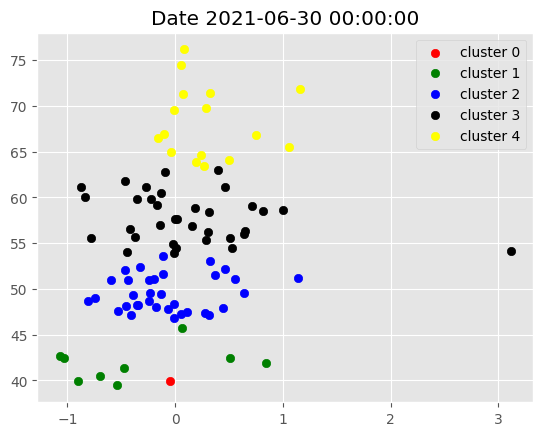

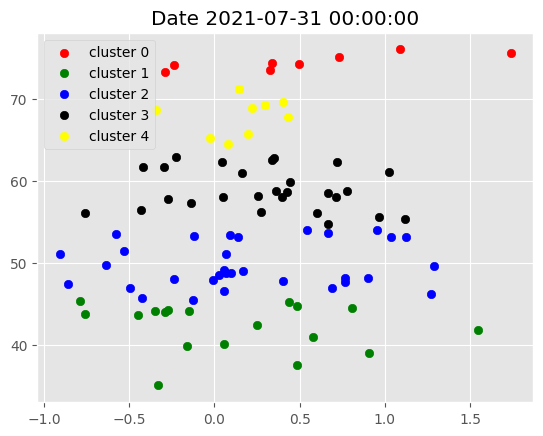

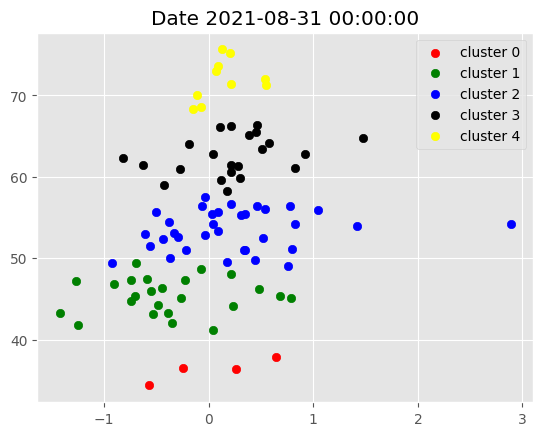

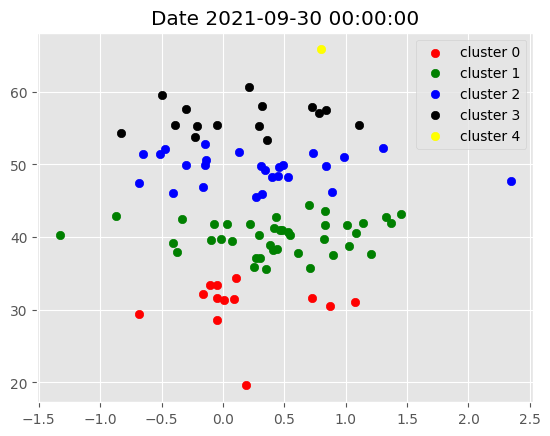

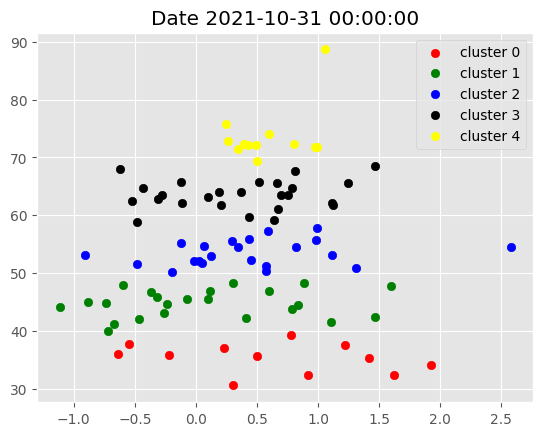

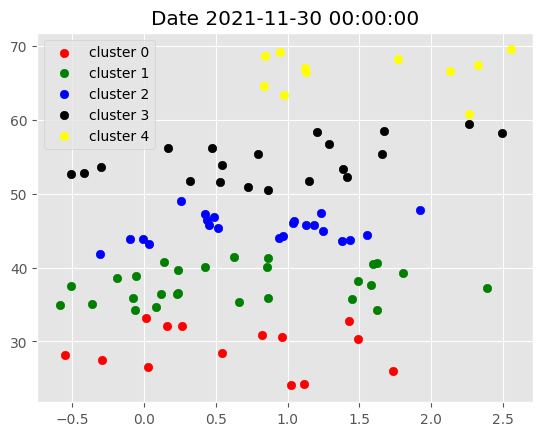

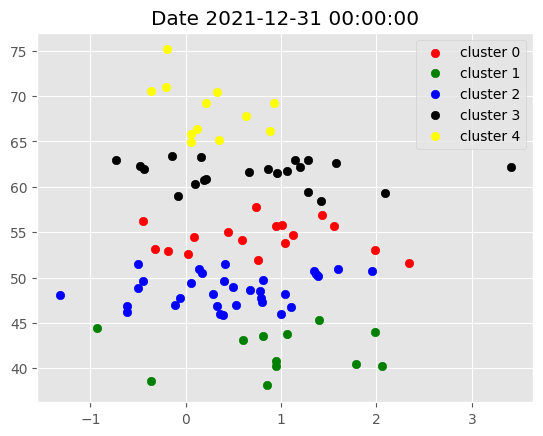

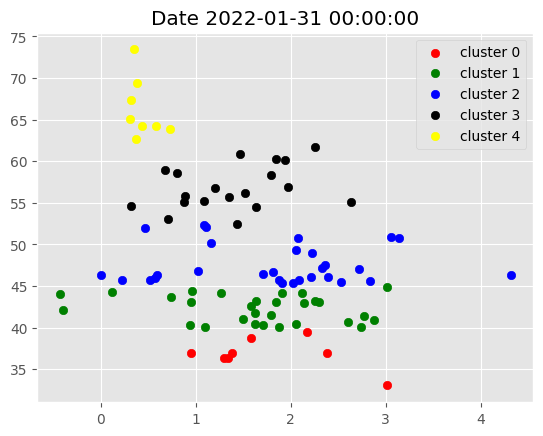

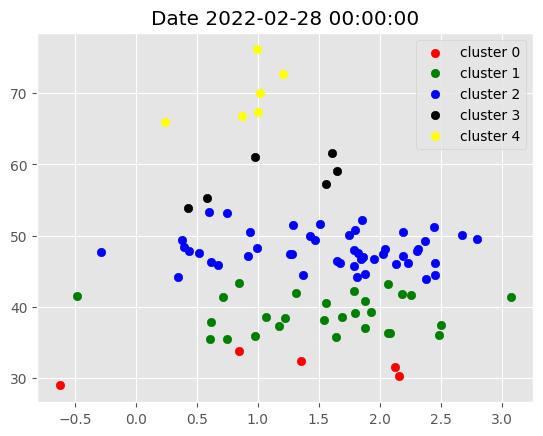

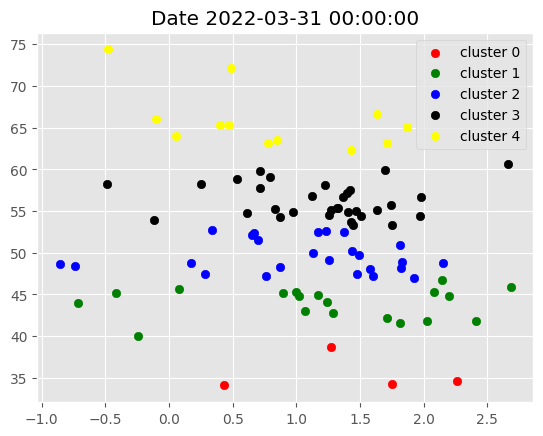

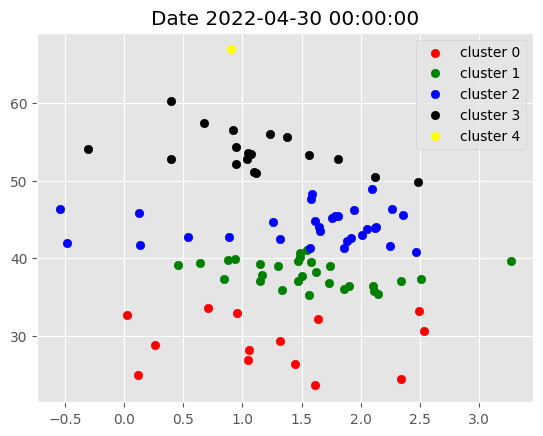

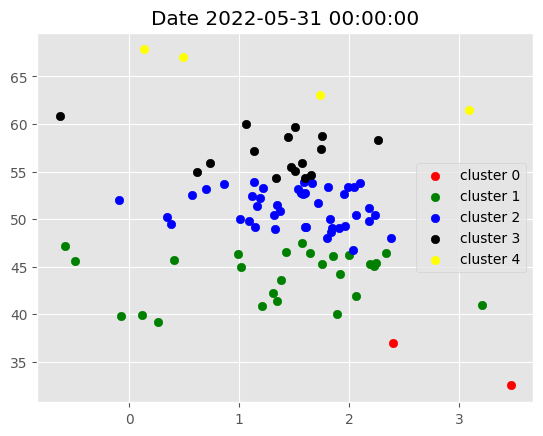

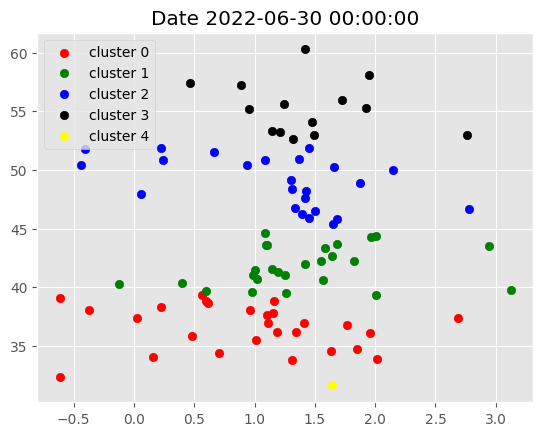

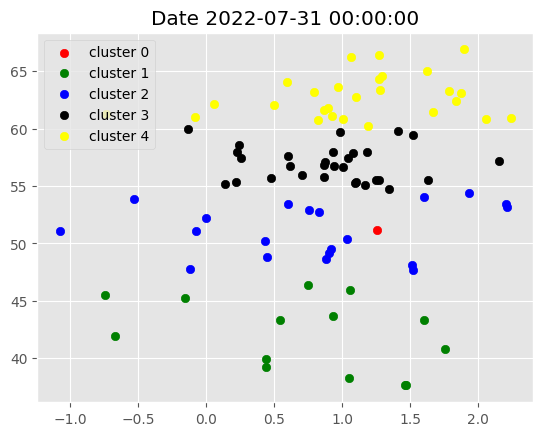

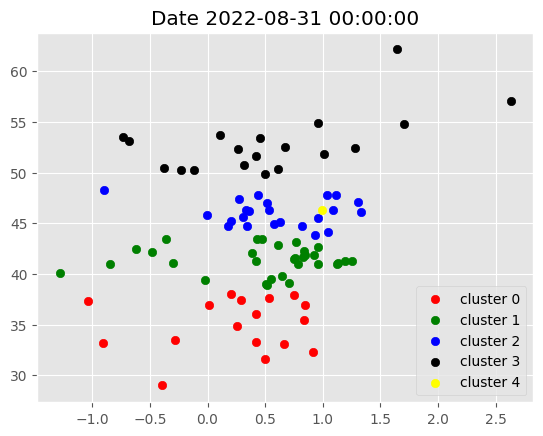

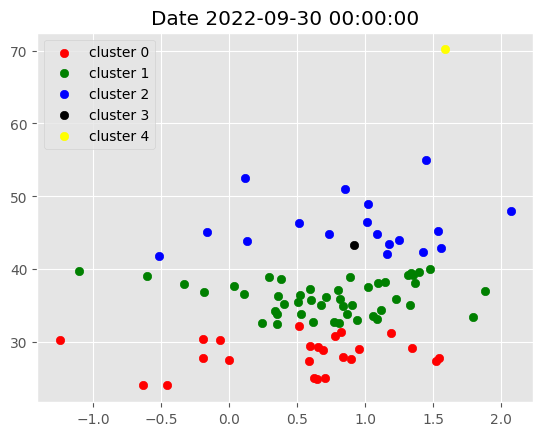

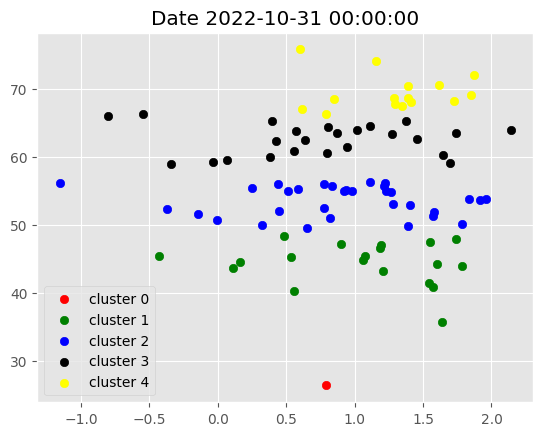

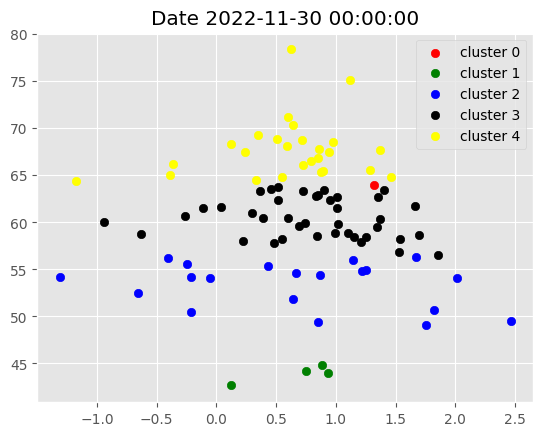

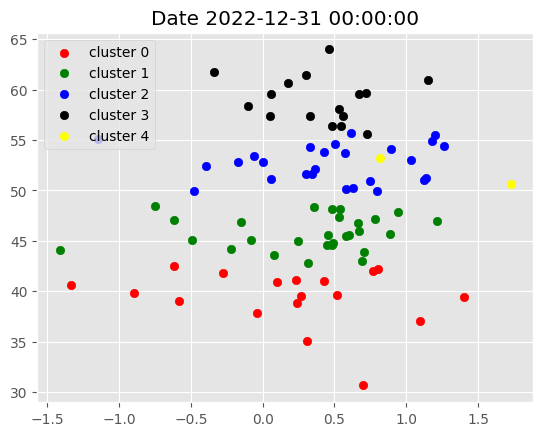

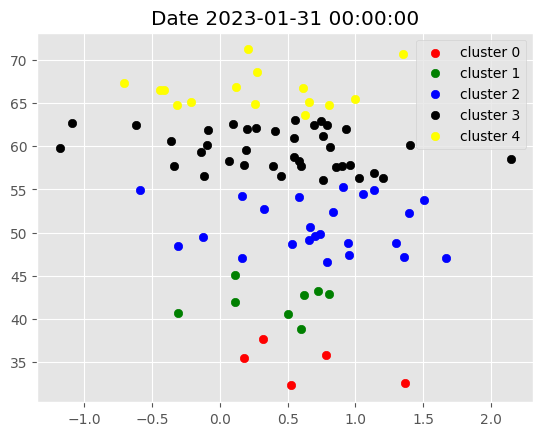

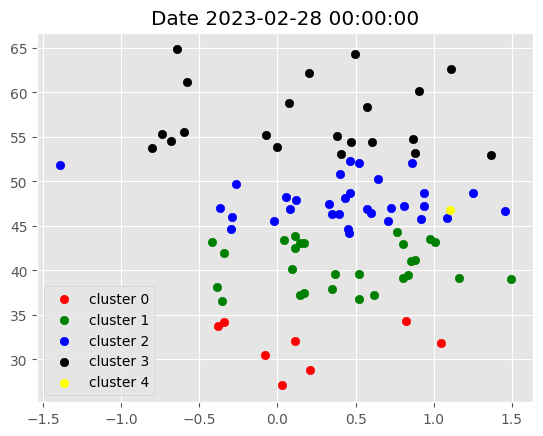

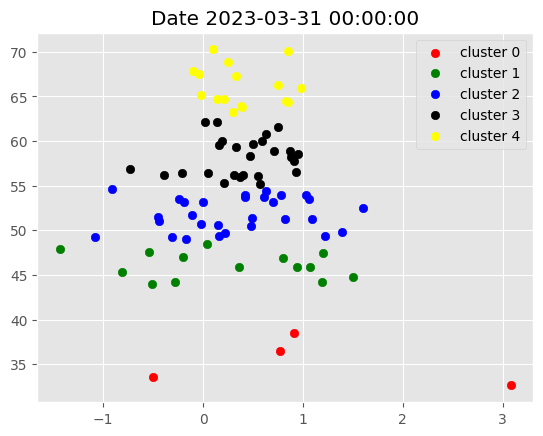

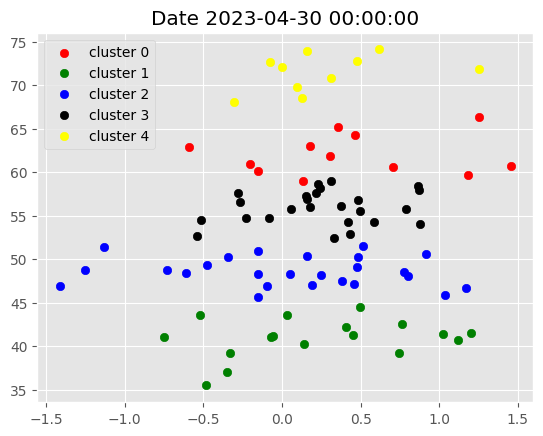

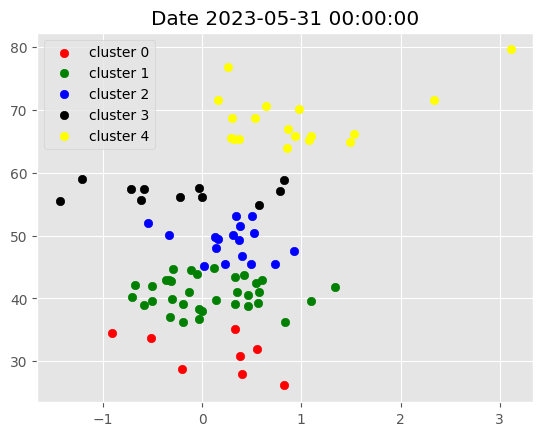

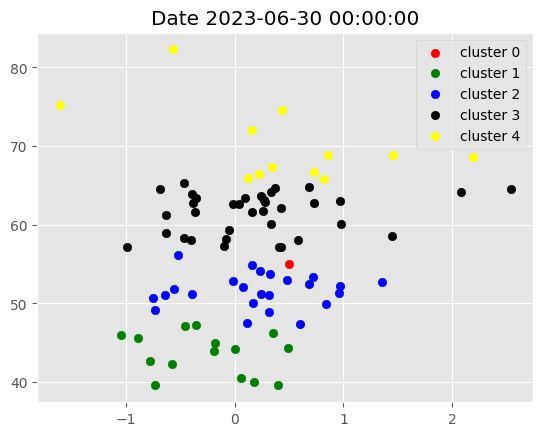

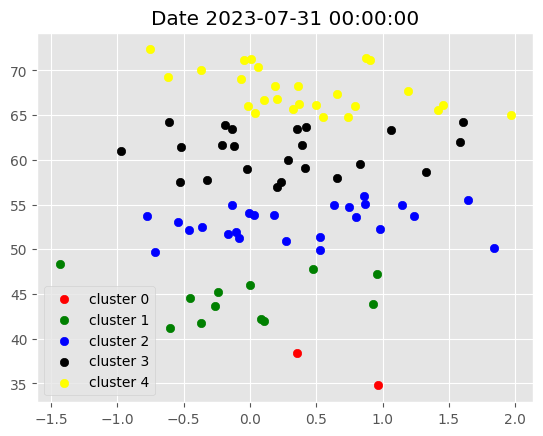

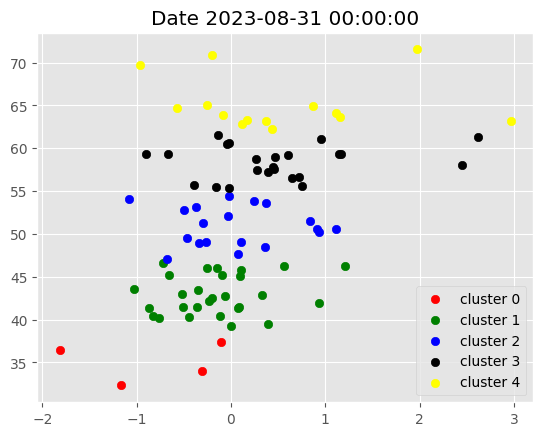

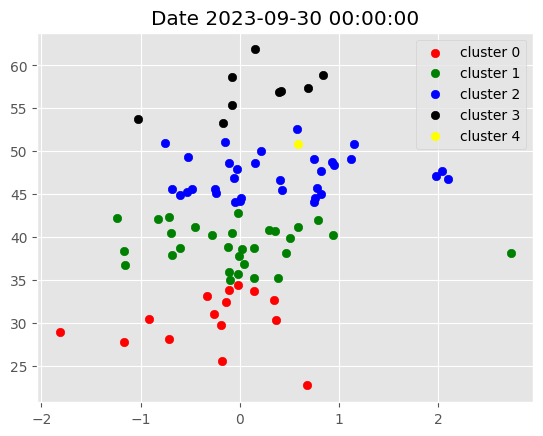

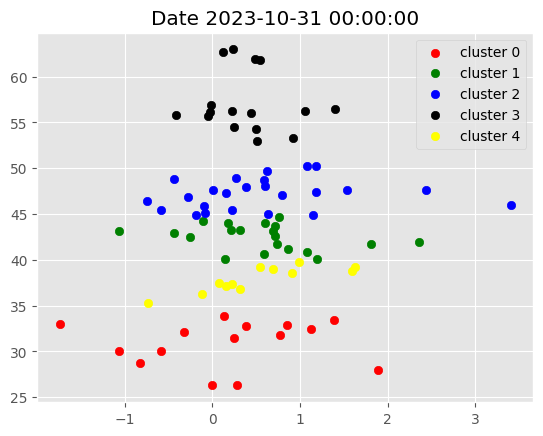

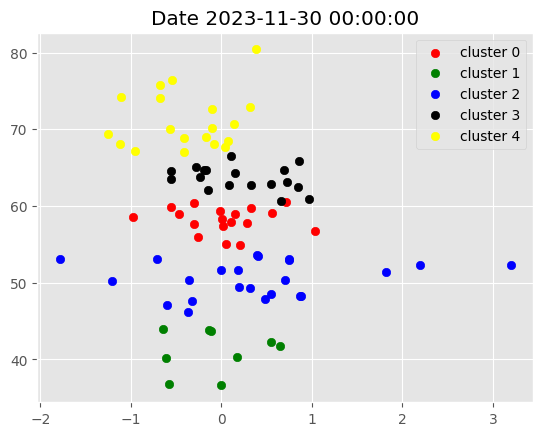

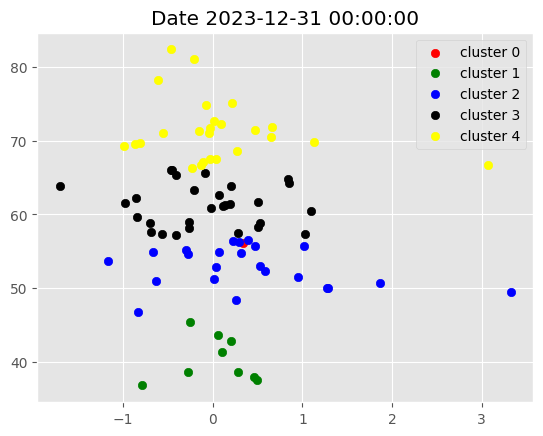

In [13]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

For each month, select assets based on their cluster and form a portfolio using Efficient Frontier's maximum Sharpe ratio portfolio optimization.

The strategy is to buy and hold stocks that are on the lower side of the RSI, but not in the oversold territory. The idea is to capitalize on stocks that are temporarily on the weaker buy side in order to capture the rebound and rebalance monthly

In [14]:
filtered_df = data[data['cluster']==1]
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1) #shift to next month

filtered_df = filtered_df.reset_index().set_index(['date','ticker'])
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
# fixed_dates

In [15]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                     frequency=252) #total trading days per year
    
    cov = risk_models.sample_cov(prices=prices,
                                frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                          cov_matrix=cov,
                          weight_bounds=(lower_bound,0.1), #max 10% for balance and diversify
                          solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [16]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                    start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                    end=data.index.get_level_values('date').unique()[-1])

new_df.head()

[*********************100%%**********************]  103 of 103 completed


Adj Close                                                          \
                  AAL       AAPL       ABBV        ABT        ADBE       AMAT   
Date                                                                            
2017-01-03  44.741222  27.023708  45.883423  34.462341  103.480003  29.419781   
2017-01-04  45.127762  26.993456  46.530384  34.735935  104.139999  29.696106   
2017-01-05  44.345036  27.130732  46.883274  35.035980  105.910004  29.567152   
2017-01-06  44.654263  27.433189  46.897972  35.989109  108.300003  29.511889   
2017-01-09  45.494976  27.684465  47.206760  35.953804  108.570000  30.193495   

                                                      ... Volume           \
              AMD        AMGN       AMZN        AVGO  ...   UBER      UNH   
Date                                                  ...                   
2017-01-03  11.43  122.248756  37.683498  141.548325  ...    NaN  3539700   
2017-01-04  11.43  123.984413  37.859001  140.540298  ...    NaN  2695200   
2017-01-05  11.24  124.073616  39.022499  138.325882  ...    NaN  2961100   
2017-01-06  11.32  127.155586  39.799500  140.159317  ...    NaN  3081300   
2017-01-09  11.49  128.826324  39.846001  140.460938  ...    NaN  3040800   

                                                                               \
                UNP         V        VZ      WBA       WFC       WMT     WYNN   
Date                                                                            
2017-01-03  3824300  13785200  22891700  4942700  22063800  10473200  2703500   
2017-01-04  3668300   8033100  18316100  4125500  15036100   7918000  2598800   
2017-01-05  4180400   7805100  13840600  7401400  18831600   7099200  2507500   
2017-01-06  3862400   8898300  15615000  3949700  18715900   9491100  1858400   
2017-01-09  2968600   7305300  14097200  3293000  21794100   8685200  2776200   

                      
                 XOM  
Date                  
2017-01-03  10360600  
2017-01-04   9434200  
2017-01-05  14443200  
2017-01-06  16518100  
2017-01-09  13762300  

[5 rows x 618 columns]

Visualise the portfolio returns and compare to SP500 returns.

In [17]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:
    
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][fixed_dates['2018-01-01']] #hard code '2017-01-03'
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df, 
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe optimization failed for {start_date}, continuing with equal-weights')
        
        if success == False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                      index=optimization_df.columns.tolist(),
                                      columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                   left_index=True,
                   right_index=True)\
            .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date','ticker']
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df],axis=0)
        
    except Exception as e:
        print(e)
 
portfolio_df = portfolio_df.drop_duplicates()

Max Sharpe optimization failed for 2022-07-01, continuing with equal-weights
Max Sharpe optimization failed for 2022-09-01, continuing with equal-weights
Max Sharpe optimization failed for 2022-10-01, continuing with equal-weights
Max Sharpe optimization failed for 2023-01-01, continuing with equal-weights
'return'


In [18]:
spy = yf.download(tickers='spy',
                 start='2015-01-01',
                 end=dt.date.today())
spy_return = np.log(spy[['Adj Close']]).diff().dropna().\
                                        rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_return,
                                 left_index=True,
                                 right_index=True)

portfolio_df.head()

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-01-02,0.021900,0.007131
2018-01-03,0.019814,0.006306
2018-01-04,0.006902,0.004206
2018-01-05,0.006430,0.006642
2018-01-08,0.005501,0.001827


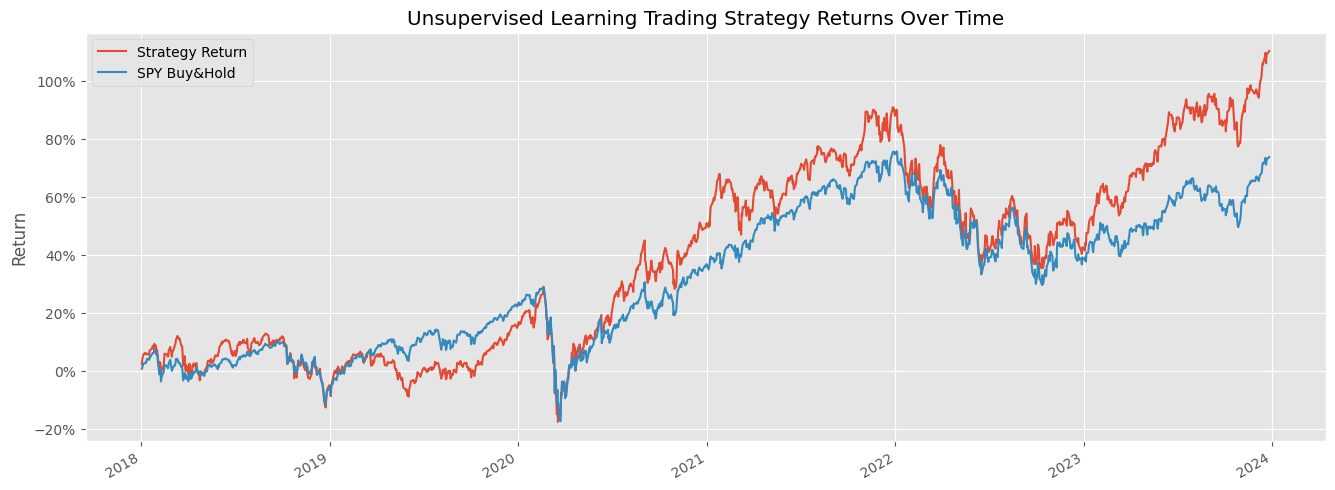

In [19]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_return[:'2023-12-26'].plot(figsize=(16,6))
plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()

#### By adjusting the parameters, we achieved results that surpassed those of SPY. Notably, the strategy excelled in terms of surpassing the lowest lows and capturing more gains during bull markets.